#Importing the required tools#

In [ ]:
import torch
from torch import nn
from torchvision.models import vgg16, VGG16_Weights
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Loading the images, model and mounting it to GPU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = vgg16(VGG16_Weights).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 156MB/s]


In [ ]:
def normalize_weights(model):
    for layer in model.features:
        if isinstance(layer, nn.Conv2d):
            # Calculate the mean activation of the filter
            mean_activation = layer.weight.data.mean()
            # Scale the weights to achieve mean activation of approximately one
            layer.weight.data /= mean_activation

In [ ]:
# model.state_dict()

In [ ]:
# model.named_children

# Pictures

In [ ]:
style_pic_path = '/content/drive/MyDrive/StyleTransfer/TheStaryNight.jpg'
content_pic_path = '/content/drive/MyDrive/StyleTransfer/Amsterdam.jpg'
new_size = (300, 300)

style_pic = (torch.tensor(cv2.cvtColor(cv2.imread(style_pic_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)) / 255.0).permute(2, 0, 1).unsqueeze(0).to(device)
content_pic = (torch.tensor(cv2.cvtColor(cv2.imread(content_pic_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)) / 255.0).permute(2, 0, 1).unsqueeze(0).to(device)

style_pic = F.interpolate(style_pic, size= new_size, mode='bilinear', align_corners=False)
content_pic = F.interpolate(content_pic, size= new_size, mode='bilinear', align_corners=False)



In [ ]:
plt.imshow(style_pic.squeeze().permute(1, 2, 0).cpu().numpy())

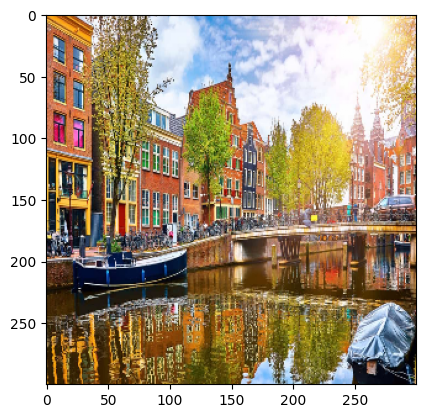

In [ ]:
plt.imshow(content_pic.squeeze().permute(1, 2, 0).cpu().numpy())

# Gram matrix

In [ ]:
class GramMatrix(nn.Module):
    def forward(self, x):
        batch, channels, height, width = x.size()
        features = x.view(batch, channels, height * width)
        gram_matrix = torch.bmm(features, features.transpose(1, 2))
        return gram_matrix
compute_gram_matrix = GramMatrix()

# Extracting the desired feature maps

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, num_layers):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential()
        i = 0
        for name, layer in model.features.named_children():
            self.features.add_module(name, layer)
            if i == num_layers:
                break
            i += 1

    def forward(self, x):
        return self.features(x)

In [ ]:
content_layer = 19
style_layers = [0, 5, 10, 17, 24]

content_feature_extractor = FeatureExtractor(model, content_layer)
model.eval()


with torch.no_grad():
    content_features = content_feature_extractor(content_pic)

style_gram_matrices = list()
for style_layer in style_layers:
    style_feature_extractor = FeatureExtractor(model, style_layer)
    with torch.no_grad():
        style_features = style_feature_extractor(style_pic)
        gram_matrix = compute_gram_matrix(style_features)
        style_gram_matrices.append(gram_matrix)

# New image

In [ ]:
# input_image = torch.rand(*list(content_pic.shape), requires_grad= True, device= device)
input_image = torch.clone(content_pic).requires_grad_()

In [ ]:
# input_image.requires_grad_()

In [ ]:
# plt.imshow(input_image.squeeze().detach().permute(1, 2, 0).cpu().numpy())

#Loss functions and hyperparameters

In [ ]:
loss_content = nn.MSELoss(reduction= 'sum')
loss_style = nn.MSELoss(reduction= 'sum')
optimizer = torch.optim.LBFGS(params= [input_image], lr=1.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer= optimizer, step_size= 20, gamma= 0.7)

In [ ]:
def calculate_gram_matrices(input_image, style_layers):
    input_gram_matrices= list()
    M = list()

    for layer_idx in style_layers:
        style_feature_extractor = FeatureExtractor(model, layer_idx)
        input_style_features = style_feature_extractor(input_image)

        gram_matrix = compute_gram_matrix(input_style_features)
        input_gram_matrices.append(gram_matrix)
        m = input_style_features[0].shape[1] * input_style_features[0].shape[2]
        M.append(m)

    return input_gram_matrices, M

In [ ]:
def calculate_style_loss(input_gram_matrices, style_gram_matrices, W: list, M: list):
    assert len(input_gram_matrices) == len(style_gram_matrices) == len(W) == len(M)
    L = len(style_gram_matrices)

    style_losses = list()

    for layer in range(L):
        N = input_gram_matrices[layer].shape[0]
        style_loss = W[layer] * (loss_style(input_gram_matrices[layer], style_gram_matrices[layer]) / (4 * N**2 * M[layer]**2))
        style_losses.append(style_loss)

    total_style_loss = sum(style_losses)

    return total_style_loss

# Generation

In [ ]:
def closure():
    optimizer.zero_grad()

    # Calculate content features and Gram matrices within the closure
    input_content_features = content_feature_extractor(input_image)
    input_gram_matrices, M = calculate_gram_matrices(input_image, style_layers)

    # Loss computation
    content_loss = loss_content(input_content_features, content_features) / 2
    style_loss = calculate_style_loss(input_gram_matrices, style_gram_matrices, W, M)

    total_loss = (a * content_loss) + (b * style_loss)
    total_loss.backward()

    return total_loss

In [ ]:
def generate(steps, W: list, a, b):
    for step in steps:
        scheduler.step()
        optimizer.step(closure)
        print(f'Step number {step}')
        plt.imshow(input_image.squeeze().permute(1, 2, 0).detach().cpu().numpy())
        plt.show()

In [ ]:
steps = range(1, 6)
W = [(1 / len(style_layers)) for x in range(len(style_layers))]
a = 1
b = 100000
generate(steps, W, a, b)
# plt.imshow(input_image.squeeze().permute(1, 2, 0).detach().cpu().numpy())
# plt.show()